In [1]:
# Imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from PrettyShortML import PrettyShortML as psml

In [2]:
# Load in sample data: regression problem
RANDOM_STATE = 42
n_samples, n_features, n_informative = (
    3000,
    15,
    7,
)
X, y = make_regression(
    n_samples=n_samples,
    n_features=n_features,
    n_informative=n_informative,
    bias=500,
    noise=150,
    random_state=RANDOM_STATE,
)
X = pd.DataFrame(X)
y = pd.DataFrame(y)
# Also, Sklearn does not like int columns
X.columns = X.columns.astype(str)
y.columns = y.columns.astype(str)


Inspect dtypes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       3000 non-null   float64
 1   1       3000 non-null   float64
 2   2       3000 non-null   float64
 3   3       3000 non-null   float64
 4   4       3000 non-null   float64
 5   5       3000 non-null   float64
 6   6       3000 non-null   float64
 7   7       3000 non-null   float64
 8   8       3000 non-null   float64
 9   9       3000 non-null   float64
 10  10      3000 non-null   float64
 11  11      3000 non-null   float64
 12  12      3000 non-null   float64
 13  13      3000 non-null   float64
 14  14      3000 non-null   float64
dtypes: float64(15)
memory usage: 351.7 KB


None



Inspect descriptive statistics:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,0.005463,0.047272,0.005080,-0.026290,-0.033599,-0.012523,0.009533,0.003973,-0.011352,0.002431,0.024210,-0.024656,0.000347,-0.010656,0.021935
std,0.993835,1.002342,1.003930,0.999280,0.972627,1.005705,1.003634,1.016384,0.991275,0.990006,0.995598,1.013139,0.967618,1.033143,0.999153
min,-3.532818,-3.495045,-3.836656,-3.635200,-3.631539,-3.393915,-4.465604,-3.922400,-3.856375,-3.448043,-3.199265,-3.436062,-3.335902,-4.295391,-3.252029
25%,-0.657488,-0.607551,-0.697512,-0.723669,-0.689405,-0.685534,-0.657767,-0.681032,-0.687175,-0.683177,-0.637211,-0.732583,-0.665261,-0.708594,-0.655179
50%,0.018924,0.032677,0.007992,-0.041359,-0.022909,-0.001835,0.004719,0.025280,-0.023982,-0.016817,0.041283,-0.031256,-0.000256,-0.000966,0.012794
75%,0.667285,0.703464,0.677094,0.678349,0.600949,0.655223,0.682207,0.703066,0.679393,0.666811,0.714147,0.650285,0.689971,0.671941,0.718164
max,3.852731,3.942331,3.428910,3.335268,3.117681,4.479084,3.529055,3.727833,3.222928,3.009862,3.377768,3.691625,3.287761,3.926238,3.264290




Top 10 value counts of feature='0':


 1.181833    1
-1.370561    1
 1.161222    1
-0.679445    1
 0.989788    1
 0.816357    1
-0.149962    1
 1.011906    1
-0.271339    1
-1.830256    1
Name: 0, dtype: int64



Top 10 value counts of feature='1':


 2.288399    1
 0.519510    1
 0.324504    1
-0.436515    1
 0.317365    1
-1.795615    1
 0.097041    1
 0.449909    1
 0.445211    1
-1.117264    1
Name: 1, dtype: int64



Top 10 value counts of feature='2':


-0.398440    1
 0.090425    1
 0.492719    1
 0.694669    1
 0.830011    1
 1.330128    1
 2.190786    1
-0.956467    1
-1.162817    1
 0.526576    1
Name: 2, dtype: int64



Top 10 value counts of feature='3':


 0.491735    1
-0.090541    1
-1.167397    1
 1.071680    1
 1.151964    1
 0.128628    1
 0.336892    1
-0.829468    1
 0.661181    1
 0.531151    1
Name: 3, dtype: int64



Top 10 value counts of feature='4':


-0.919125    1
 0.635131    1
-1.133075    1
 0.881059    1
 1.521388    1
-1.904093    1
 0.810542    1
 0.384851    1
 1.376934    1
 1.022926    1
Name: 4, dtype: int64



Top 10 value counts of feature='5':


 0.131767    1
 0.255659    1
 0.798461    1
-0.194491    1
-0.465814    1
-0.308592    1
 1.253932    1
 0.893004    1
-1.214044    1
-0.887314    1
Name: 5, dtype: int64



Top 10 value counts of feature='6':


 1.240527    1
-0.207629    1
-0.262164    1
 1.608067    1
-0.021989    1
-1.069198    1
 0.385527    1
 0.661940    1
-0.791227    1
 1.725958    1
Name: 6, dtype: int64



Top 10 value counts of feature='7':


-0.767911    1
-1.014661    1
-1.505571    1
 0.188631    1
-2.100251    1
 0.224190    1
-0.196569    1
 0.388959    1
-1.512629    1
-0.491635    1
Name: 7, dtype: int64



Top 10 value counts of feature='8':


 0.197441    1
-1.943805    1
-1.486162    1
 0.047299    1
 1.260145    1
 0.086027    1
 1.979334    1
 1.349473    1
-0.491016    1
 0.903843    1
Name: 8, dtype: int64



Top 10 value counts of feature='9':


-0.392025    1
-1.375940    1
 0.555294    1
-1.700627    1
-0.815088    1
 1.086670    1
-0.546688    1
-0.208493    1
 0.055753    1
-1.854136    1
Name: 9, dtype: int64



Top 10 value counts of feature='10':


 0.926956    1
 1.093223    1
-0.745879    1
 0.295225    1
-2.010886    1
 0.668479    1
 1.578856    1
 1.021398    1
 0.667536    1
 0.126875    1
Name: 10, dtype: int64



Top 10 value counts of feature='11':


 2.392327    1
-1.064533    1
-0.335038    1
-1.035604    1
 1.560801    1
-0.320798    1
-0.270012    1
-0.782943    1
-0.942871    1
-1.433507    1
Name: 11, dtype: int64



Top 10 value counts of feature='12':


-0.318243    1
-0.646248    1
 0.181271    1
 0.665878    1
-1.698710    1
 0.448459    1
-0.100602    1
-0.088832    1
 1.377577    1
 0.891764    1
Name: 12, dtype: int64



Top 10 value counts of feature='13':


 0.482378    1
 0.122832    1
 1.463901    1
-0.976946    1
 1.147129    1
-1.598574    1
-1.851657    1
 0.997421    1
-1.547242    1
-0.686550    1
Name: 13, dtype: int64



Top 10 value counts of feature='14':


-1.520706    1
-0.316063    1
 1.325309    1
-0.734743    1
 0.868153    1
 0.057330    1
-0.134615    1
-0.330824    1
 1.034826    1
 0.661654    1
Name: 14, dtype: int64



Amount of NaNs per feature:


0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
dtype: int64

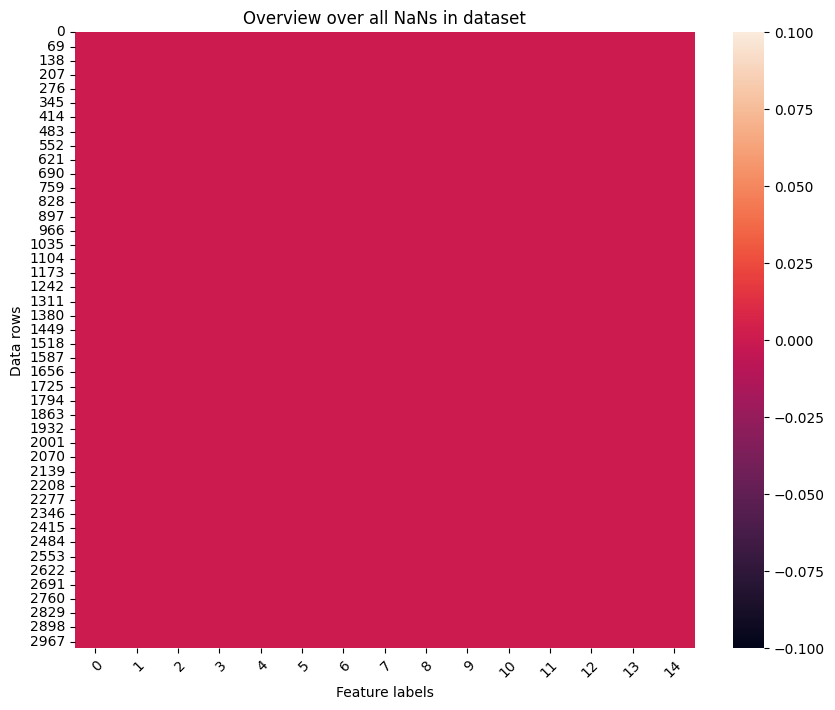

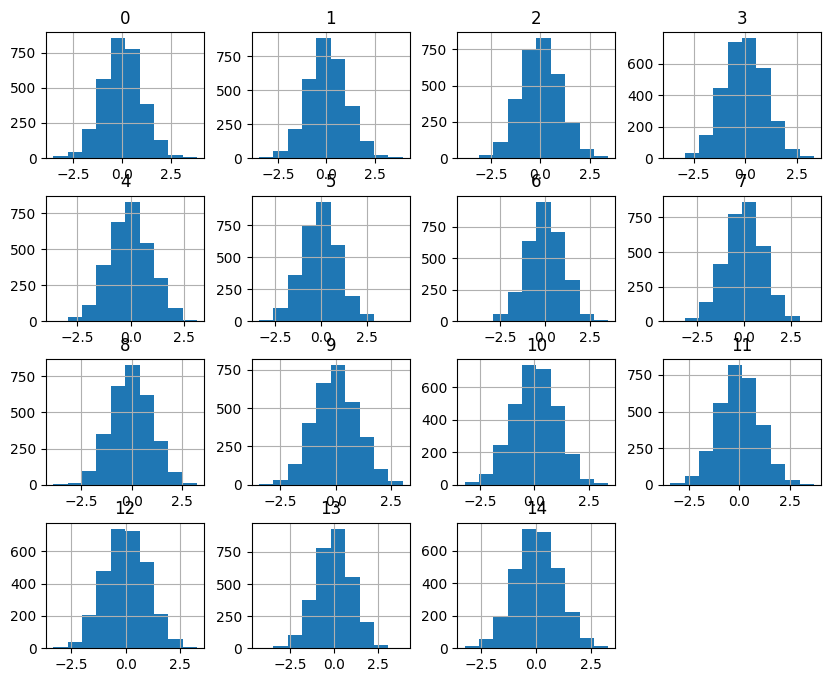

In [3]:
# Do basic EDA
psml.eda_clean_check(X)

In [4]:
# This data is workable, so let's load a class instance after doing a train-test split
data_train, data_test, labels_train, labels_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE
)
my_dataset = psml(
    X_train=data_train,
    X_test=data_test,
    y_train=labels_train,
    y_test=labels_test,
)

Starting to plot pairplots. Depending on the dateset size, this may take a while... 
Should it take too long, consider changing the default 'kind' parameter to something else than 'reg'.


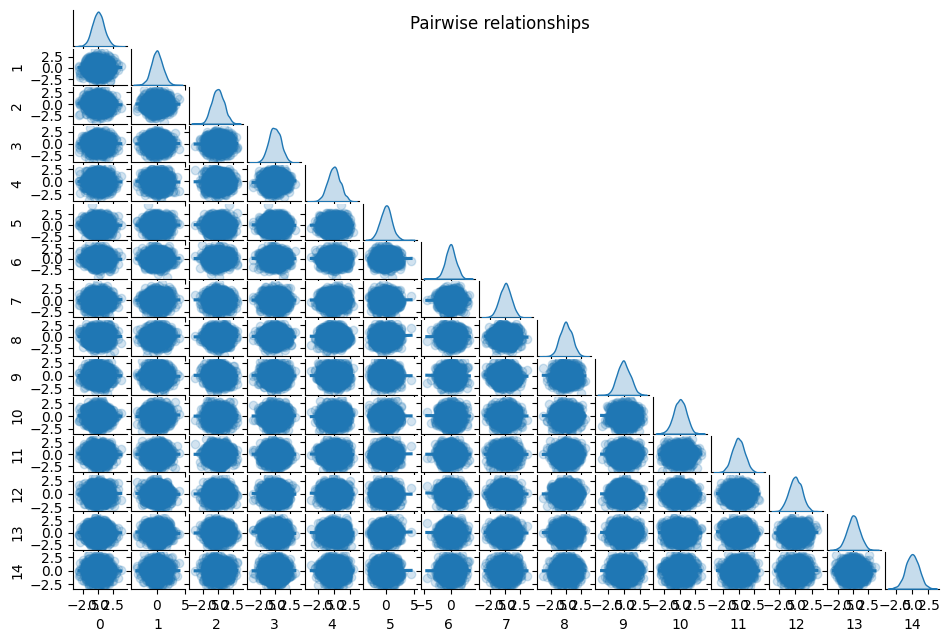

In [5]:
# Plot feature pair plots to inspect distributions and linear relationships
_plotting_ax = my_dataset.plot_eda_pairplot(
    my_dataset.X_train, corner=True, dropna=False, plot_hist=False, fig_size=(9, 6)
)

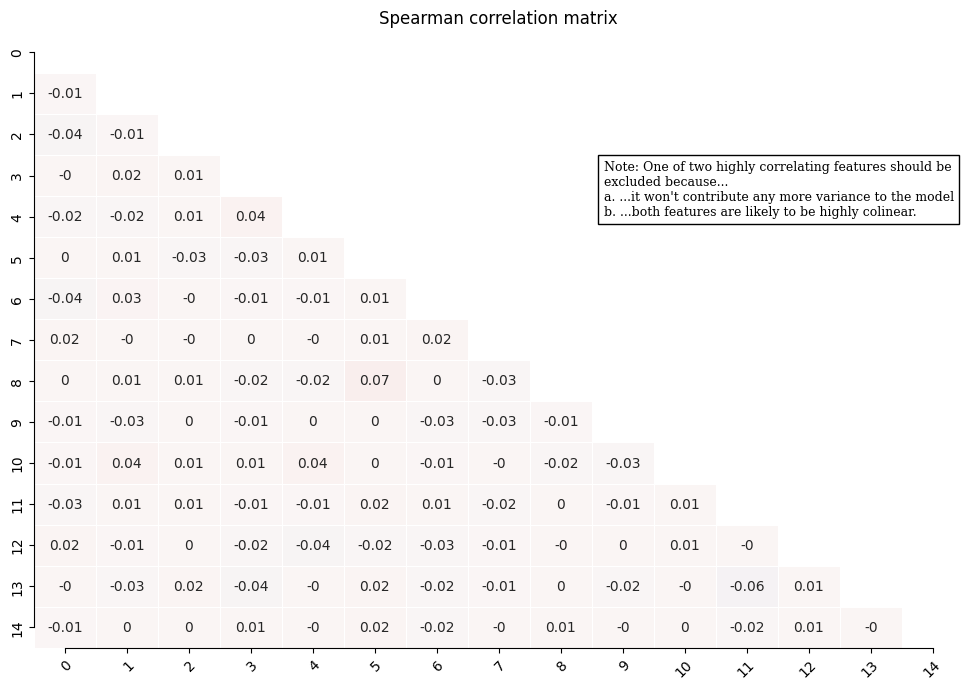

In [6]:
# Plot feature correlation matrix to spot colinearity
_plotting_ax = my_dataset.plot_eda_corr_mat(
    my_dataset.X_train, metric="spearman", cmap="vlag", mask=True, annot=True
)

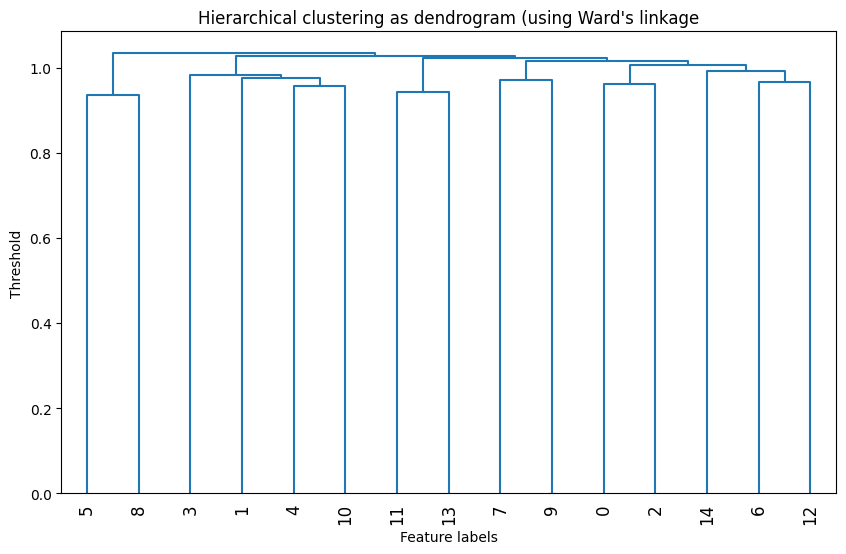

In [7]:
# Normally, we'd do a decent amount of feature cleaning and engineering here.
# For now, let's just do hierarchical clustering on the features' rank-order correlations
# to select features.
# We could run the following to just inspect clustering:
# _plotting_ax, dist_linkage = my_dataset.plot_hierarchical_clustering(
#     data=my_dataset.X_train
# )
# When we know the threshold we want to choose, we can run:
selected_features = my_dataset.cluster_informed_feature_selection(
    data=my_dataset.X_train, cluster_threshold=0.5
)
# Select the features
# In this example, this will essentially selected all features.
my_dataset.X_train = my_dataset.X_train.iloc[:, selected_features]
my_dataset.X_test = my_dataset.X_test.iloc[:, selected_features]

In [8]:
# let's train the model now using a CV splitter and some
# params to do gridsearch. Model_train runs SimpleImputer and StandardScaler on default
# for numerical features. We can use the instance instead of passing the data explicitly.
cv_splitter = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
param_grid = {
    "estimator__fit_intercept": (True, False),
}
pipeline, training_score = my_dataset.model_train(
    LinearRegression(),
    numeric_features=tuple(my_dataset.X_train.columns),
    param_grid=param_grid,
    cv=cv_splitter,
    n_jobs=-1,
    refit=True,
)
print(f"The model's performance on training data:\n{training_score:.4f}")

Building and fitting LinearRegression estimator...
set_config() got an unexpected keyword argument 'transform_output' Couldn't set sklearn's set_config. Is your sklearn version 1.2+ ?


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ('0',
                                                                          '1',
                                                                          '2',
                                                                          '3',
                                                                          '4',
                                                                          '5',
                                                                          '6',
                                                                          '7',
                                                                          '8',
                                                                          '9',
                                                                          '10',
                                                                          '11',
                                                                          '12',
                                                                          '13',
                                                                          '14'))])),
                                       ('estimator', LinearRegression())]),
             n_jobs=-1, param_grid={'estimator__fit_intercept': (True, False)})

model_train took 2.263 secs to run.

The model's performance on training data:
0.5968


In [9]:
# Let's evaluate our model on the test data
# First, retrieve our scoring metric
# CV was already applied so just predict b/c the model is refit on the best model performance
print(
    "The score on predicting the test data using the best model is"
    f" {pipeline.score(my_dataset.X_test, my_dataset.y_test):.3f}."
)

The score on predicting the test data using the best model is 0.617.


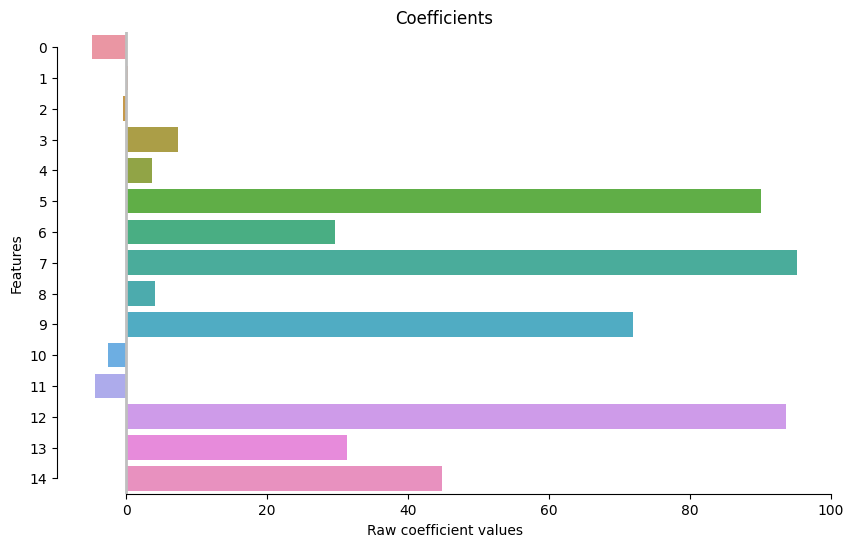

In [10]:
# Now, plot our coefficients
_plotting_ax = my_dataset.plot_reg_coefficients(coefs=pipeline.best_estimator_["estimator"].coef_, zero_line=True)

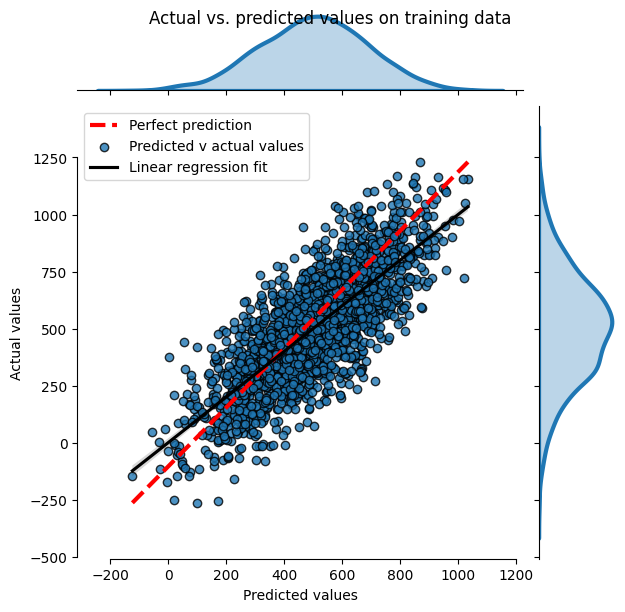

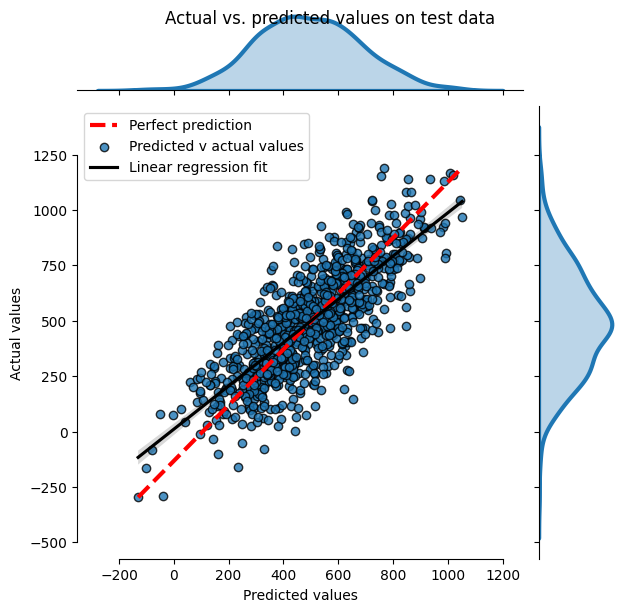

In [11]:
# Now our predictions against the real values
y_train_pred = pipeline.predict(my_dataset.X_train)
y_test_pred = pipeline.predict(my_dataset.X_test)
_plotting_axes = my_dataset.plot_reg_prediction_errors(
    y_train=my_dataset.y_train,
    y_train_pred=y_train_pred,
    y_test=my_dataset.y_test,
    y_test_pred=y_test_pred,
    plotting_residuals=False,
)

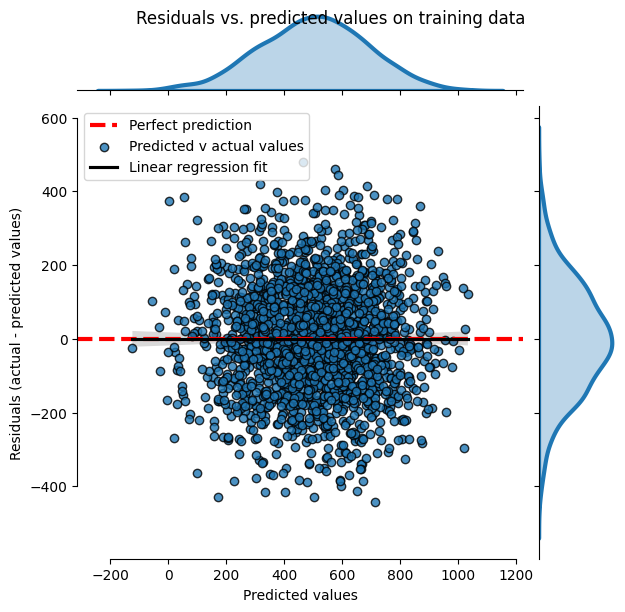

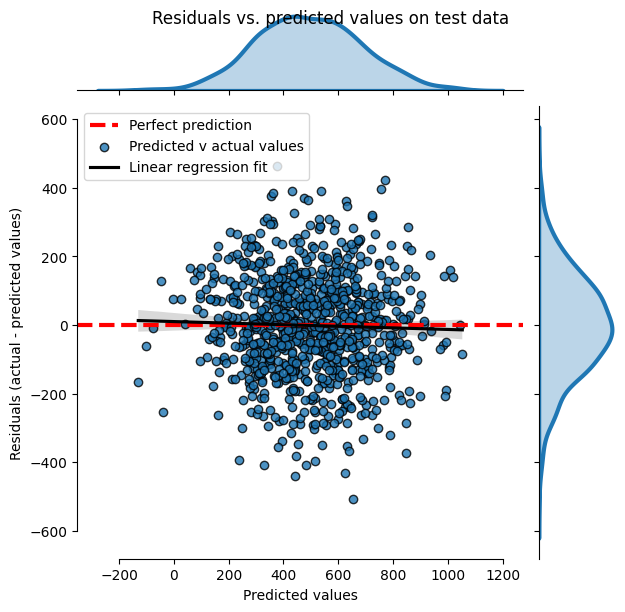

In [12]:
# Finally, plot our predictions against the residuals
residuals_train = my_dataset.y_train.iloc[:, 0] - y_train_pred
residuals_test = my_dataset.y_test.iloc[:, 0] - y_test_pred
_plotting_axes = my_dataset.plot_reg_prediction_errors(
    y_train=residuals_train,
    y_train_pred=y_train_pred,
    y_test=residuals_test,
    y_test_pred=y_test_pred,
    plotting_residuals=True,
)